<font color=brown><h1><center>Project: $101^{st}$Illinois General Assembly Public Act Prediction</center></h1></font>

<a id='bp'></a>
<font color=blue><h1>Part 1: Business Problem</h1></font>

**Objective:** "To estimate how much one additional democrat sponsor changes the probability that a bill is a **Public Act**."

To construct a dataset by web scraping the data available on the ILGA website. There are 6 variables that are useful for analyzing and predicting how much one democrat sponsor impact the Public Act bill.
# <img src="https://i.ibb.co/3N79dWn/101st-General-Assembly2.jpg" width="800" height = "500"/>

The dataset for this project is taken from the [Illinois General Assembly](http://www.ilga.gov/legislation/default.asp). The dataset includes the **Senate Bills** and **House Bills** introduced in the **$101^{st}$ General Assembly**.

<font color=blue><h1>Part 2: Implementation</h1></font>

## Importing Libraries 

In [2]:
# Importing libraries neccessary for this project
import pandas as pd
import numpy as np
import seaborn as sns
# Pretty display for notebooks
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import shuffle
from sklearn import tree
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import time
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [3]:
# Importing libraries needed for web scraping 
from requests import get
from bs4 import BeautifulSoup
import re

## Web Scraping 

In [ ]:
def get_urls(b_url, b_folder, main_url):
    base_url = b_url
    base_folder = b_folder
    senete_house_100s_urls = []
    senete_house_bill_urls = []
#     house_bills = []
    soup = BeautifulSoup(get(main_url).text)
    for link in soup.find_all('a'):
        burl = link.get('href')
        if burl and 'SB' in burl:
            surl = base_url+base_folder+burl
            senete_house_100s_urls.append(surl)
        elif burl and 'HB' in burl:
            hurl = base_url+base_folder+burl
            senete_house_100s_urls.append(hurl)
            
    for url in senete_house_100s_urls:
        soup_bill = BeautifulSoup(get(url).text)
        for link in soup_bill.find_all('a'):
            ssurl = link.get('href')
    #         print(ssurl)
            if ssurl and 'DocTypeID=SB' in ssurl:
                senete_house_bill_urls.append(base_url+ssurl)
            elif ssurl and 'DocTypeID=HB' in ssurl:
                senete_house_bill_urls.append(base_url+ssurl)

    
    return senete_house_bill_urls

**Extracting data from each bill**

In [ ]:
def get_content(b_url, urls=[]):
    urls = urls
    base_url = b_url
#     base_folder = b_folder
    df = pd.DataFrame(columns=['URL', 'Chamber', 'Bill Number', 'No of Amendments', 'No of Republican sponsors','No of Democrat sponsors', 'Public Act'])
    for url in urls:
        lurl = str(url)
#         print(f'Processing start')
        soup = BeautifulSoup(get(url).text)
        
        def find_bill_cham():
            pattn = 'HB[0-9]*'
            name= re.findall(pattn, soup.title.string)
            if name:
                return name[0][:2], name[0][2:]
            else:
                pattn = 'SB[0-9]*'
                name= re.findall(pattn, soup.title.string)
                return name[0][:2], name[0][2:]
        
        def get_sponsers(url, b_url):
            d_count =0
            r_count =0
            ssoup = BeautifulSoup(get(url).text)
            for link in ssoup.find_all('a'):
                spnsrs = link.get('href')
                if spnsrs and 'Rep' in spnsrs:
                    soup1 = BeautifulSoup(get(base_url+spnsrs).text)
                    if '(D)' in  soup1.find('span', text = re.compile('Rep')).find_next('span').string:
                        d_count += 1
                    elif '(R)' in  soup1.find('span', text = re.compile('Rep')).find_next('span').string:
                        r_count += 1
                elif spnsrs and 'Senator' in spnsrs:
                    soup1 = BeautifulSoup(get(base_url+spnsrs).text)
                    if '(D)' in  soup1.find('span', text = re.compile('Sen')).find_next('span').string:
                        d_count += 1
                    elif '(R)' in  soup1.find('span', text = re.compile('Sen')).find_next('span').string:
                        r_count += 1
                    
            return d_count, r_count
        
        def is_p_act():
            table = soup.find(text = 'Last Action').findNext('table')
            tdl = []
            for td in table.findChildren('td'):
                tdl.append(td.text)
            if 'Public Act' in tdl[-1]:
                return 1
            else:
                return 0
        
            
        
        chamber, bill_no = find_bill_cham()
        n_amen = len(soup.find_all(text =re.compile('Amendment No. [0-9]$')))
        D_cnt, R_cnt = get_sponsers(url, b_url)
        p_act = is_p_act()
        
        df = df.append({'URL':lurl, 'Chamber':chamber, 'Bill Number': bill_no, 'No of Amendments':n_amen, 'No of Republican sponsors':R_cnt,'No of Democrat sponsors':D_cnt, 'Public Act':p_act}, ignore_index=True)
    

    return df

base_url = 'http://ilga.gov'
base_folder = '/legislation/'
main_url = 'http://ilga.gov/legislation/default.asp'

all_bills = get_urls(base_url,base_folder,main_url )
leg101st_df = get_content(base_url, all_bills)

## Loading the data

In [ ]:
# Storing the extracted data into a csv file
leg101st_df.to_csv('Assembly2.csv', index = False)

In [4]:
# Loading the data into a dataframe 
Columns = ['Chamber', 'Bill Number', 'No of Amendments', 'No of Republican sponsors', 'No of Democrat sponsors', 'Public Act']
data_df = pd.read_csv('Assembly.csv') 
data_df = data_df[Columns]

In [5]:
# Chamber takes 1 for house bill and 0 for senate bill
data_df['Chamber'] = data_df['Chamber'].map({'HB': 1, 'SB': 0})

<font color=blue><h1>Part 3: Exploratory Data Analysis</h1></font>

In [6]:
# Information related to the data_df
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6115 entries, 0 to 6114
Data columns (total 6 columns):
Chamber                      6115 non-null int64
Bill Number                  6115 non-null int64
No of Amendments             6115 non-null int64
No of Republican sponsors    6115 non-null int64
No of Democrat sponsors      6115 non-null int64
Public Act                   6115 non-null int64
dtypes: int64(6)
memory usage: 286.7 KB


In [7]:
# Memory usage of each column in data_df
data_df.memory_usage(deep=True)

Index                           80
Chamber                      48920
Bill Number                  48920
No of Amendments             48920
No of Republican sponsors    48920
No of Democrat sponsors      48920
Public Act                   48920
dtype: int64

In [8]:
# Look at the first few rows of the data set
data_df.head()

,Chamber,Bill Number,No of Amendments,No of Republican sponsors,No of Democrat sponsors,Public Act
0,0,1,1,0,32,1
1,0,2,0,0,1,0
2,0,3,0,0,1,0
3,0,4,0,0,1,0
4,0,5,0,0,1,0


In [9]:
# The dimension of the data_df
data_df.shape

(6115, 6)

In [10]:
# Counting the number of rows and columns in data_df
nrows = data_df.shape[0]
ncols = data_df.shape[1]
print('There are %d rows and %d columns in data_df'%(nrows, ncols))

There are 6115 rows and 6 columns in data_df


In [11]:
# Checking NAN in each column in data_df
data_df.isnull().sum(axis = 0)

Chamber                      0
Bill Number                  0
No of Amendments             0
No of Republican sponsors    0
No of Democrat sponsors      0
Public Act                   0
dtype: int64

**There are no null values in our data_df**

In [12]:
# Number of Classes in the data
data_df['Public Act'].nunique()

2

**There are 2 class labels in data_df**

Text(0.5, 1.0, 'Number of Public Act vs Other Act bills')

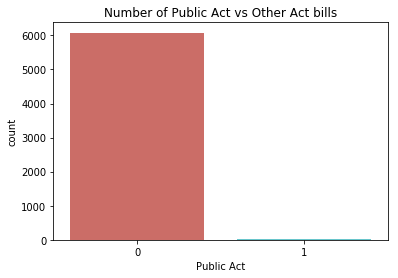

In [13]:
sns.countplot(x = 'Public Act', data=data_df, palette = 'hls')
plt.title('Number of Public Act vs Other Act bills')

In [14]:
# Displays the counts and percentage of the labels.
lb = data_df['Public Act']
df_perc = pd.concat([lb.value_counts(),              
lb.value_counts(normalize=True).mul(100)],axis=1,keys=('Counts','Percentage (%)'))
print(df_perc)

   Counts  Percentage (%)
0    6078        99.39493
1      37         0.60507


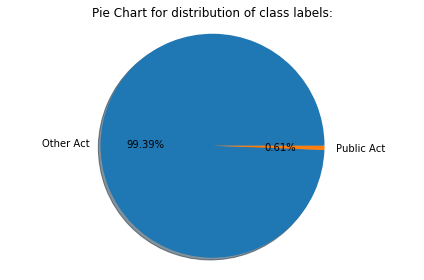

In [15]:
# Pie chart for distribution of class labels
labels = ['Other Act', 'Public Act']
sizes = df_perc.Counts.tolist()
explode = (0, 0)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.2f%%',
        shadow=True, startangle=360)# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal') 
plt.title('Pie Chart for distribution of class labels:')
plt.tight_layout()
plt.show()

Since there are 2 classes in the data this is a **Binary Classification** Problem

## The Dataset Feature/Attribute Information:

•   *Chamber* : takes the value 1 for house and 0 for senate <br>
•	*Bill Number* : this is a unique identifier (integer) for each bill introduced in the 101st Illinois General assembly <br>
•	*Number of Amendments* <br>
•	*Number of Republican sponsors* <br>
•	*Number of Democrat sponsors* <br>
•	*Public Act* : A variable that takes the value 1 if the outcome is “PUBLIC ACT” and 0 otherwise.


## Feature Exploration

Observe a statistical description of the dataset, check the relevance of each feature.


In [16]:
# Description related to the data_df
display(data_df.describe())

,Chamber,Bill Number,No of Amendments,No of Republican sponsors,No of Democrat sponsors,Public Act
count,6115.000000,6115.000000,6115.000000,6115.000000,6115.000000,6115.000000
mean,0.629926,1632.476533,0.158626,0.742927,2.737204,0.006051
std,0.482864,1041.231070,0.524215,2.368003,6.709919,0.077557
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,765.000000,0.000000,0.000000,1.000000,0.000000
50%,1.000000,1529.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,2323.500000,0.000000,1.000000,2.000000,0.000000
max,1.000000,3852.000000,5.000000,55.000000,94.000000,1.000000


In [17]:
# Counting the number of Public Act bills in the data
data_df['Public Act'].value_counts()
num_pub_act = data_df['Public Act'][data_df['Public Act'] == 1].count()
num_pub_act

37

In [18]:
# Counting the number of Democrat Sponsors in the data
total_rep = data_df['No of Republican sponsors'].sum()
total_demo = data_df['No of Democrat sponsors'].sum()
print('There are %d Democrat and %d Republican sponsors in data_df'%(total_demo, total_rep))

There are 16738 Democrat and 4543 Republican sponsors in data_df


## Univariate Analysis

In [19]:
from pyforest import *

### Frequency Distribution of Chamber:

**Chamber:** 
This is a categorical variable that takes 0 for **Senate Bill** and 1 for **House Bill**. <br>
Let's take a look at the frequency distribution of these two bills. <br>
There are **3852** House Bills and **2263** Senate Bills in the $101^{st}$ General Assembly. 


In [20]:
# Number of acts in House Bills(1) and Senate Bills(0)
data_df.Chamber.value_counts()

1    3852
0    2263
Name: Chamber, dtype: int64

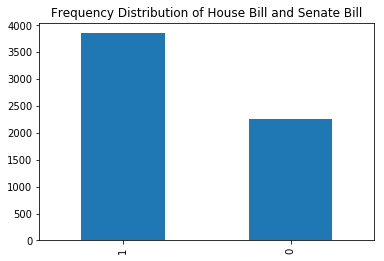

In [21]:
# Plot for frquency distribution of the Chamber
data_df['Chamber'].value_counts().plot.bar(title="Frequency Distribution of House Bill and Senate Bill")

### Frequency Distribution of Amendments:

**No of Amendments:**  This is a numerical variable that indicates amendments.<br>
There are 504 amendments in Senate Bill and 466 in House Bill.<br>

In [22]:
# Number of amendments for Senate Bill and House Bill
data_df.groupby(['Chamber'])['No of Amendments'].agg('sum')

Chamber
0    504
1    466
Name: No of Amendments, dtype: int64

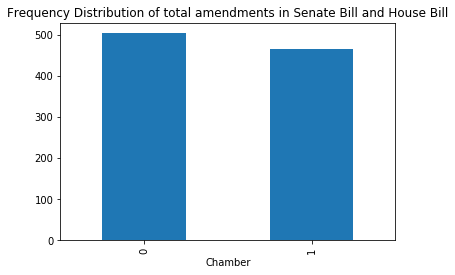

In [23]:
# freq distribution plot for total amendments 
data_df.groupby(['Chamber'])['No of Amendments'].agg('sum').plot.bar(title="Frequency Distribution of total amendments in Senate Bill and House Bill")

In [24]:
# Frequency and total of amendments for each bill
data_df.groupby(['Chamber', 'No of Amendments'])['No of Amendments'].agg('sum')

Chamber  No of Amendments
0        0                     0
         1                   194
         2                   170
         3                    90
         4                    40
         5                    10
1        0                     0
         1                   216
         2                   162
         3                    72
         4                    16
Name: No of Amendments, dtype: int64

### Frequency Distribution of Number of Republicans Sponsors

**No of Republican Sponsors:** This is a numerical variable that indicates republican sponsors.<br>
There are total **1631** republican sponsors in Senate Bill and **2912** in House Bill.



In [25]:
# Number of Republicans in each Bill
data_df.groupby(['Chamber'])['No of Republican sponsors'].agg('sum')

Chamber
0    1631
1    2912
Name: No of Republican sponsors, dtype: int64

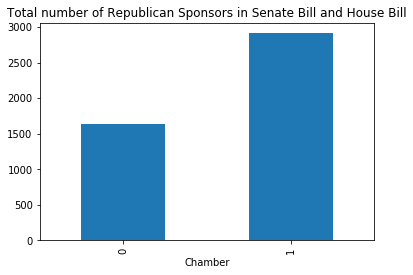

In [26]:
# Total Number of Republicans sponsors
data_df.groupby(['Chamber'])['No of Republican sponsors'].agg('sum').plot.bar(title="Total number of Republican Sponsors in Senate Bill and House Bill")

### Frequency Distribution of Number of Democrat Sponsors

**No of Democrat Sponsors:** This is a numerical variable that indicates democrat sponsors. <br>
There are total **6746** democrat sponsors in Senate Bill and **9992** in House Bill.

In [27]:
# Number of Democrat in each Bill
data_df.groupby(['Chamber'])['No of Democrat sponsors'].agg('sum')

Chamber
0    6746
1    9992
Name: No of Democrat sponsors, dtype: int64

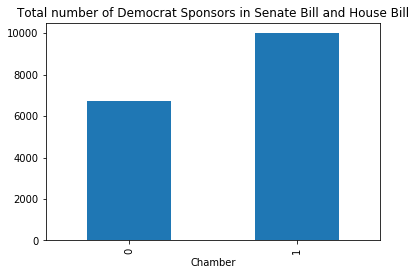

In [28]:
# Total Number of Democrat sponsors
data_df.groupby(['Chamber'])['No of Democrat sponsors'].agg('sum').plot.bar(title="Total number of Democrat Sponsors in Senate Bill and House Bill")

c:\users\ebhavaniprasad\pycharmprojects\test\venv\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
c:\users\ebhavaniprasad\pycharmprojects\test\venv\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


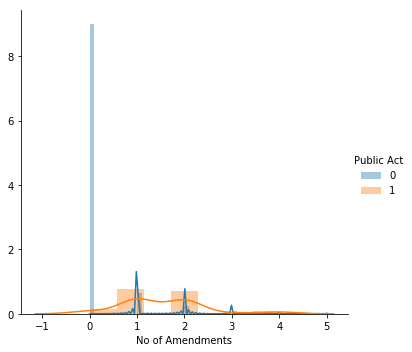

In [29]:
# distribution plot
sns.FacetGrid(data_df, hue="Public Act", size=5).map(sns.distplot, "No of Amendments").add_legend()

c:\users\ebhavaniprasad\pycharmprojects\test\venv\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


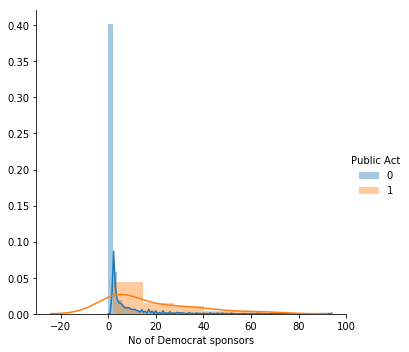

In [30]:
# distribution plot
sns.FacetGrid(data_df, hue="Public Act", size=5).map(sns.distplot, "No of Democrat sponsors").add_legend()

c:\users\ebhavaniprasad\pycharmprojects\test\venv\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


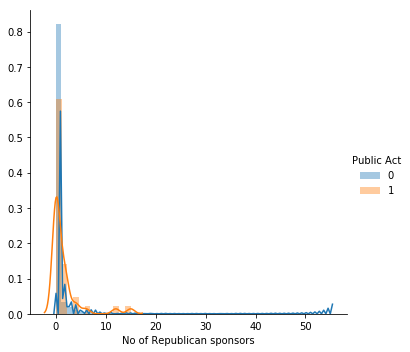

In [31]:
# distribution plot
sns.FacetGrid(data_df, hue="Public Act", size=5).map(sns.distplot, "No of Republican sponsors").add_legend()

## Bivariate Analysis

### Violin Plot

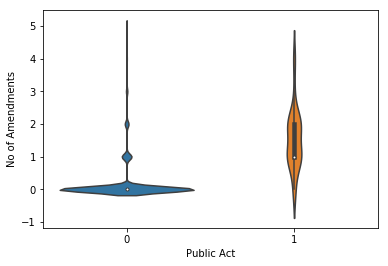

In [32]:
sns.violinplot(x="Public Act", y="No of Amendments", data=data_df, size=8)
plt.show()

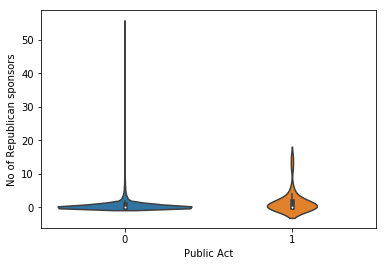

In [33]:
sns.violinplot(x="Public Act", y="No of Republican sponsors", data=data_df, size=8)
plt.show()

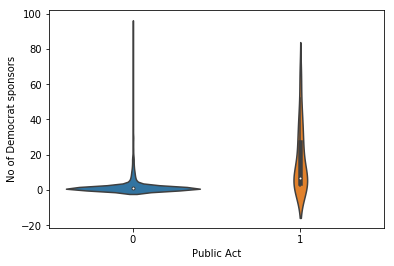

In [34]:
sns.violinplot(x="Public Act", y="No of Democrat sponsors", data=data_df, size=8)
plt.show()

## Multivariate Analysis

### Pairplot

Plot pairwise relationships in a dataset.

c:\users\ebhavaniprasad\pycharmprojects\test\venv\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
c:\users\ebhavaniprasad\pycharmprojects\test\venv\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
c:\users\ebhavaniprasad\pycharmprojects\test\venv\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
c:\users\ebhavaniprasad\pycharmprojects\test\venv\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


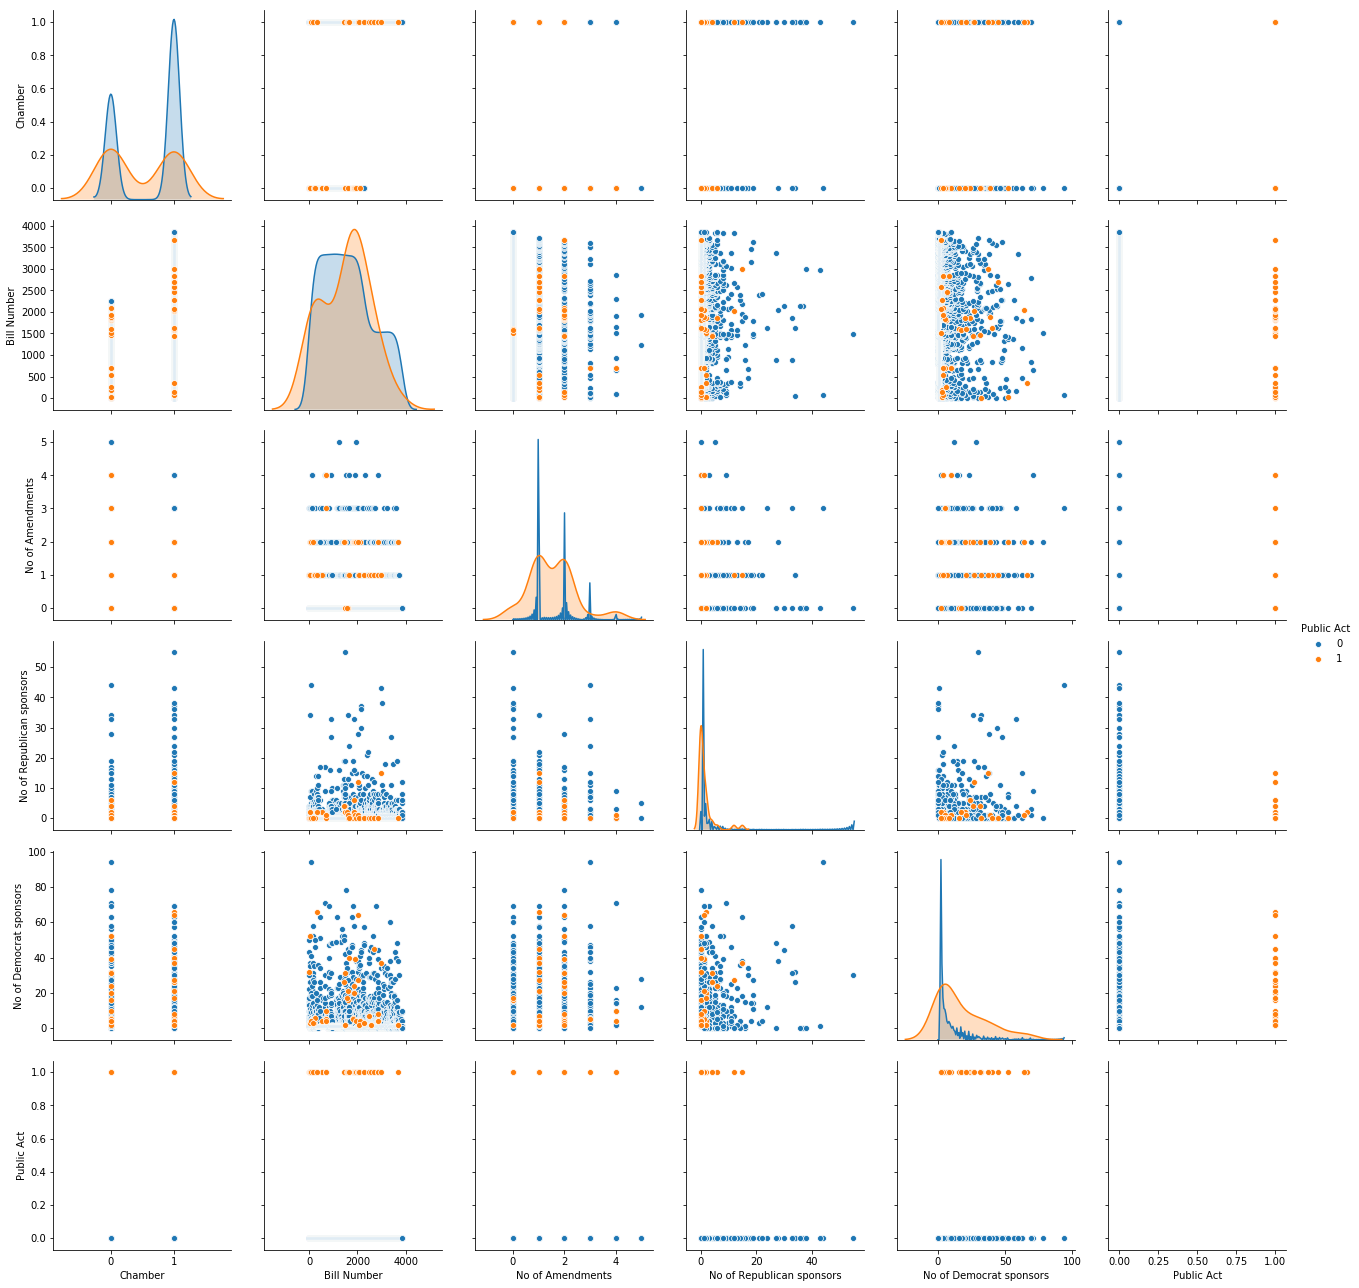

In [35]:
sns.pairplot(data_df, hue="Public Act", size=3)
plt.show()

### Correlation Matrix & Heatmap

**Moderate Positively Correlated Features:**
1. Public Act vs No of Amendments:        0.205697
2. Public Act vs No Democrat sponsors:    0.171832
3. No of Amendments vs No of Republicans: 0.196106

**Highly Positively Correlated Features:**
1. No of Amendments vs No of Democrat sponsors: 0.439974

**Highly Negatively Correlated Features:**
1. No of Amendments vs Chamber: -0.093712 	 

**Let's Think:**

1. What features affect our target variable the most (Public Act)?
2. What features have strong correlations with each other?
3. Can we do a more in depth examination of these features?

**Summary:**

From the heatmap, there is a **positive(+)** correlation between No of Amendments, No of Democrat sponsors, and No of Republican sponsors. Which could mean that the these 3 features can influence the Public Act.

For the **negative(-)** relationships, No of Amendments and Chamber are highly correlated.

The correlation is high for No of Amendments vs Public Act: **0.205697**. So Public Act bills are influenced by No of Amendments.

In [36]:
# Correlation Matrix
data_df.corr()

,Chamber,Bill Number,No of Amendments,No of Republican sponsors,No of Democrat sponsors,Public Act
Chamber,1.000000,0.368444,-0.093712,0.007187,-0.027851,-0.023179
Bill Number,0.368444,1.000000,0.000689,0.046282,0.020959,-0.008421
No of Amendments,-0.093712,0.000689,1.000000,0.196106,0.439974,0.205697
No of Republican sponsors,0.007187,0.046282,0.196106,1.000000,0.285692,0.027173
No of Democrat sponsors,-0.027851,0.020959,0.439974,0.285692,1.000000,0.171832
Public Act,-0.023179,-0.008421,0.205697,0.027173,0.171832,1.000000


Text(0.5, 1.0, 'Heatmap of Correlation Matrix')

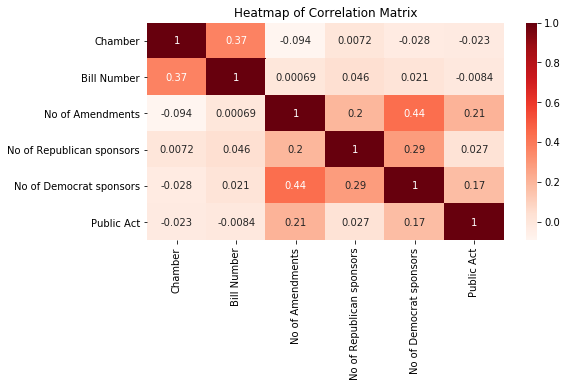

In [37]:
# Heatmap 
plt.figure(figsize=(8,4))
sns.heatmap(data_df.corr(),cmap='Reds',annot=True)
plt.title('Heatmap of Correlation Matrix')

<font color=brown><h1>Statistical Overview:</h1></font>

1. There are **37** Public Act Bills in the data <br>
2. There are total **6115** bills/rows in the data <br>
3. There are **6078** Other bills (non-public act bills) <br>
4. Total number of Democrat sponsors in the data = **16738** <br>
5. Total number of Republican sponsors in the data = **4543**
6. This is a **Binary Classification** problem
7. The class distribution for this dataset is highly imbalanced
8. This is a **Class Imbalanced Problem**

# Feature Scaling

In [38]:
# Separating predictors and labels in data_df
#data_df = shuffle(data_df)
label_act = data_df.loc[:, data_df.columns == 'Public Act']
data_df_feature = data_df.loc[:, data_df.columns != 'Public Act']
label_act

,Public Act
0,1
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [39]:
# Standard normalization 
scaler = StandardScaler()
scaler.fit(data_df_feature)
standar_scaled_df = scaler.transform(data_df_feature)
standar_scaled_df = pd.DataFrame(standar_scaled_df, columns= data_df_feature.columns)
standar_scaled_df

c:\users\ebhavaniprasad\pycharmprojects\test\venv\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\ebhavaniprasad\pycharmprojects\test\venv\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


,Chamber,Bill Number,No of Amendments,No of Republican sponsors,No of Democrat sponsors
0,-1.304671,-1.567001,1.605149,-0.313761,4.361482
1,-1.304671,-1.566040,-0.302623,-0.313761,-0.258922
2,-1.304671,-1.565080,-0.302623,-0.313761,-0.258922
3,-1.304671,-1.564119,-0.302623,-0.313761,-0.258922
4,-1.304671,-1.563159,-0.302623,-0.313761,-0.258922
5,-1.304671,-1.562198,-0.302623,-0.313761,-0.258922
6,-1.304671,-1.561238,-0.302623,-0.313761,0.188214
7,-1.304671,-1.560277,-0.302623,-0.313761,-0.258922
8,-1.304671,-1.559317,5.420693,0.953232,6.000980
9,-1.304671,-1.558357,1.605149,1.375564,1.827712


<font color=Blue><h1>Part 4: Modeling</h1></font>

**Machine Learning Model:**  Logistic Regression 

Since this is a binary classification problem(two classes- Public Act or Others). So here I'm using the Logistic Regression classifier to estimate how much one additional democrat sponsor changes the probability that a bill is a Public Act.

In [40]:
standar_scaled_df_features = standar_scaled_df
type(standar_scaled_df_features)
labels
clf = LogisticRegression(random_state=0, solver='liblinear', multi_class='ovr').fit(standar_scaled_df_features, label_act)
clf.coef_
clf.predict_proba(standar_scaled_df_features)
#clf.intercept_

c:\users\ebhavaniprasad\pycharmprojects\test\venv\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[0.96306734, 0.03693266],
       [0.99643805, 0.00356195],
       [0.99643812, 0.00356188],
       ...,
       [0.99801677, 0.00198323],
       [0.99739926, 0.00260074],
       [0.99721703, 0.00278297]])

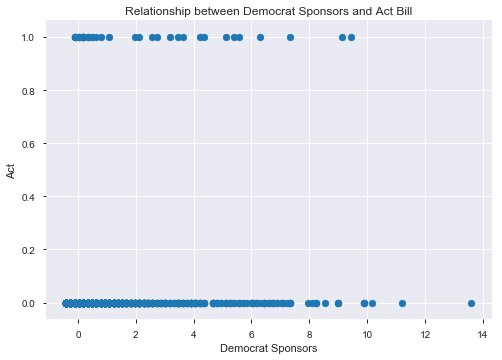

In [41]:
demo_features = standar_scaled_df_features['No of Democrat sponsors']

plt.scatter(y = label_act, x = demo_features)

plt.title('Relationship between Democrat Sponsors and Act Bill')

plt.xlabel('Democrat Sponsors')

plt.ylabel('Act')

plt.show()

In [42]:
# One additional democrat sponsor changes the probablity that a bill is a Public Act

dataset = standar_scaled_df_features.join(label_act)

result1 = clf.predict_proba(standar_scaled_df_features)
probability1 = result1[0, 1]
probability1

0.03693265528834529

In [43]:
# Adding one to the Democrat sponsors column to see how much it will change the probability of Public Act Bill
standar_scaled_df_features_added = standar_scaled_df_features
standar_scaled_df_features_added['No of Democrat sponsors'] = standar_scaled_df_features_added['No of Democrat sponsors']+1

result2 = clf.predict_proba(standar_scaled_df_features_added)
result2
probability2 = result2[0, 1]
probability2

0.049127845314517624

**Calculating the Probability Change**

In [44]:
probability_change = (probability2-probability1)*100
probability_change

1.2195190026172336

### Class Imbalance Problem

**Problem:** 
Most machine learning algorithms work best when the number of samples in each class are about equal. This is because most algorithms are designed to maximize accuracy and reduce error.

**Objective:**
Our objective will be to correctly classify the minority class of Public Act

**Description:**
1. This is a scenario where the number of observations belonging to one class is significantly lower than those belonging to the other classes. 
2. In this situation, the predictive model developed using conventional machine learning algorithms could be biased and inaccurate. 
3. The goal is to improve identification of the rare minority class as opposed to achieving higher overall accuracy. 
4. Standard classifier algorithms like Decision Tree and Logistic Regression have a bias towards classes which have number of instances. They tend to only predict the majority class data(Other Act). The features of the minority class(Public Act) are treated as noise and are often ignored. Thus, there is a high probability of misclassification of the minority class as compared to the majority class.

**Approach:** 
1. Choosing the Right **Performance Metric**
2. Choosing the Right **Algorithm** (Model)
3. Resampling Techniques: 
                 a) Random Oversampling: Oversample minority class
                 b) Random Undersampling: Undersample majority class
4. Informed Oversampling Technique: **SMOTE** (Synthetic Minority Oversampling TEchnique)

**Splitting the data into train and test sets**

In [45]:
data_train, data_test, label_train, label_test = train_test_split(
...     data_df_feature, label_act, test_size= 0.30, random_state=27)

data_train.shape

(4280, 5)

In [46]:
# Concatenate our training data back together
trainingset_data = pd.concat([data_train, label_train], axis=1)
testingset_data = pd.concat([data_test, label_test], axis=1)

# Separate minority (Public Act Bills) and majority classes (Other Act Bills)
not_public = trainingset_data[trainingset_data['Public Act']==0]
public = trainingset_data[trainingset_data['Public Act']==1]
len(public)

24

#### Random Oversampling 

In [47]:
def Oversampling(public, not_public):
    # upsample minority (Oversampling)
    public_upsampled = resample(public,
                          replace=True, # sample with replacement
                          n_samples=len(not_public), # match number in majority class
                          random_state=27) # reproducible results
    # combine majority and upsampled minority
    upsampled = pd.concat([not_public, public_upsampled])
    
    # Training data after applying Oversampling(Upsampling)
    train_label_oversampled = upsampled['Public Act']
    train_feature_oversampled = upsampled.drop('Public Act', axis=1)
    
    return upsampled, train_feature_oversampled, train_label_oversampled    

In [48]:
upsampled, train_feature_oversampled, train_label_oversampled = Oversampling(public, not_public)

In [49]:
# check new class counts
upsampled['Public Act'].value_counts()

1    4256
0    4256
Name: Public Act, dtype: int64

#### Random Undersampling

In [50]:
def Undersampling(public, not_public):
    # downsample majority (Undersampling)
    not_public_downsampled = resample(not_public,
                                replace = False, # sample without replacement
                                n_samples = len(public), # match number in minority class
                                random_state = 27) # reproducible results
    # combine minority and downsampled majority
    downsampled = pd.concat([not_public_downsampled, public])
    
    # Training data after applying Undersampling(Downsampling)
    train_label_undersampled = downsampled['Public Act']
    train_feature_undersampled = downsampled.drop('Public Act', axis = 1)
    
    return downsampled, train_feature_undersampled, train_label_undersampled    

In [51]:
downsampled, train_feature_undersampled, train_label_undersampled = Undersampling(public, not_public)

In [52]:
# check new class counts
downsampled['Public Act'].value_counts()

1    24
0    24
Name: Public Act, dtype: int64

#### SMOTE (Synthetic Minority Oversampling TEchnique)

In [53]:
def SMOTE1(data_train,label_train):
    sm = SMOTE(random_state = 42, ratio = 1.0)
    smote_feature_train, smote_label_train = sm.fit_sample(data_train,label_train)
    smote_feature_train_df = pd.DataFrame(smote_feature_train, columns = data_train.columns)
    smote_label_train_df = pd.DataFrame(smote_label_train, columns = label_train.columns)
    return smote_feature_train_df, smote_label_train_df

In [54]:
# Training data after applying SMOTE
smote_feature_train_df, smote_label_train_df = SMOTE1(data_train,label_train)

c:\users\ebhavaniprasad\pycharmprojects\test\venv\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [55]:
# combine feature and label for dataframe
smote_df = pd.concat([smote_feature_train_df, smote_label_train_df])

# check new class counts
smote_df['Public Act'].value_counts()

c:\users\ebhavaniprasad\pycharmprojects\test\venv\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


1.0    4256
0.0    4256
Name: Public Act, dtype: int64

# Performance Metric we are interested in 

**Recall/Sensitivity:** The number of True Positives(TP) divided by the number of positive values in the test data(TP+FN). Recall is also called Sensitivity or the True Positive Rate(TPR). It is a measure of a classifier’s completeness. Low recall indicates a high number of False Negatives(FN). <br>

<left> Recall = TP/(TP+FN)</left>

**False Negative Rate (FNR):** The number of False Negatives(FN) divided by the number of positive values in the test data(TP+FN).

FNR = FN/(TP+FN)

**Matthews Correlation Coefficient (MCC):** The Matthews correlation coefficient is used in machine learning as a measure of the quality of binary and multiclass classifications. It takes into account true and false positives and negatives and is generally regarded as a **balanced** measure which can be used even if the classes are of **very different sizes**. The MCC is in essence a correlation coefficient value between -1 and +1. A coefficient of +1 represents a **perfect prediction**, 0 an **average random prediction** and -1 an **inverse prediction**. The statistic is also known as the **phi coefficient**.

**Confusion Matrix:** This is a graphical representation of the TP, FP, FN and TN.

## Logistic Regression

In [56]:
# Logistic Regression

def LogisticReg(data_train, data_test, label_train, label_test):
    
    start = time.time()
    
    # Logistic Regression model trains the data 
    lr = LogisticRegression(solver='liblinear').fit(data_train, label_train)
    
    # Predicting the results for test data
    lr_pred = lr.predict(data_test)
    
    end = time.time()
    
    # Accuracy Score 
    accuracy = accuracy_score(label_test, lr_pred)
    # F1 Score
    f1score = f1_score(label_test, lr_pred)
    # Recall Score
    recall = recall_score(label_test, lr_pred)
    # Precision Score
    precision = precision_score(label_test, lr_pred)
    # Matthews Correlation Coefficient (MCC)
    mcc = matthews_corrcoef(label_test, lr_pred) 
    
    
    # ROC Curve and AUROC Score.
    roc_auc = roc_auc_score(label_test, lr_pred)
    
    fpr4, tpr4, thresholds4 = roc_curve(label_test, lr_pred)
    plt.figure()
    plt.plot(fpr4, tpr4, label='Logistic Regression (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

    print('Area Under the Curve (AUC):  ', roc_auc)
        
    print('Time took for training and predicting the results: {0:.5} seconds\n'.format(float(end-start)))
    
    # Checking unique values
    predictions = pd.DataFrame(lr_pred)
    counts = predictions[0].value_counts()
    
    
    # Confusion Matrix 
    cm = confusion_matrix(label_test, lr_pred)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells    
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Other Act', 'Public Act']); ax.yaxis.set_ticklabels(['Other Act', 'Public Act']);
   
    #FNR - False Negative Rate 
    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TP = cm[1][1]
    
    FNR = FN/(FN+TP)
    
    return accuracy, counts, f1score, recall, precision, cm, FNR, mcc 

**Logistic Regression with Imbalanced (Original) Dataset** 

c:\users\ebhavaniprasad\pycharmprojects\test\venv\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


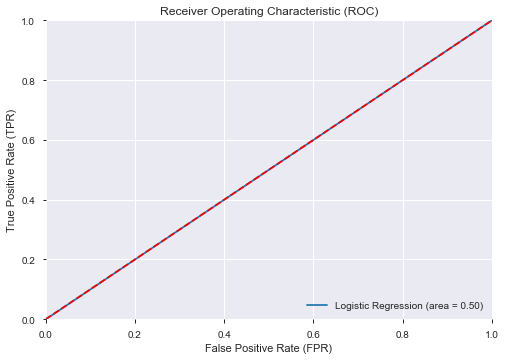

Area Under the Curve (AUC):   0.4997255762897914
Time took for training and predicting the results: 0.062484 seconds

Accuracy for Logistic Regression with Imbalanced data (Original):  0.9923705722070845
Recall for Logistic Regression with Imbalanced data (Original):  0.0
F1 score for Logistic Regression with Imbalanced data (Original):  0.0
Precision for Logistic Regression with Imbalanced data (Original):  0.0
FNR for Logistic Regression with Imbalanced data (Original):  1.0
Mathews Correlation Coefficient for Logistic Regression with Imbalanced data (Original): -0.00197 


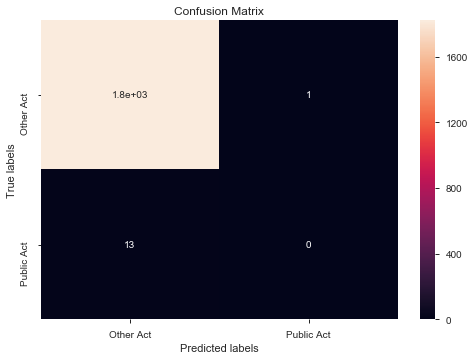

In [57]:
accuracy_lr1, counts_lr1, f1score_lr1, recall_lr1, precision_lr1, cm_lr1, FNR_lr1, mcc1 = LogisticReg(data_train, data_test, label_train, label_test)
print('Accuracy for Logistic Regression with Imbalanced data (Original): ', accuracy_lr1)
print('Recall for Logistic Regression with Imbalanced data (Original): ', recall_lr1)
print('F1 score for Logistic Regression with Imbalanced data (Original): ', f1score_lr1)
print('Precision for Logistic Regression with Imbalanced data (Original): ', precision_lr1)
print('FNR for Logistic Regression with Imbalanced data (Original): ', FNR_lr1)
print('Mathews Correlation Coefficient for Logistic Regression with Imbalanced data (Original): {0:.3} '.format(mcc1))

**Logistic Regression with Balanced Dataset After Applying Random Oversampling**

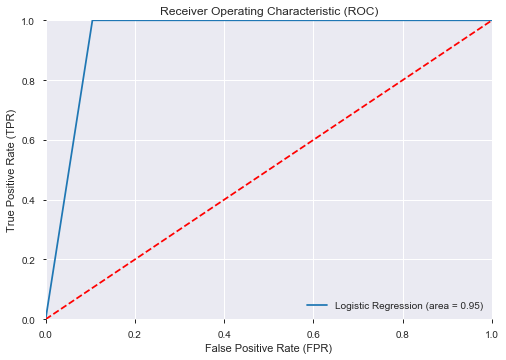

Area Under the Curve (AUC):   0.9475850713501647
Time took for training and predicting the results: 0.031275 seconds

Accuracy for Logistic Regression After Random Oversampling:  0.8959128065395096
Recall for Logistic Regression After Random Oversampling:  1.0
F1 score for Logistic Regression After Random Oversampling:  0.11981566820276497
Precision for Logistic Regression After Random Oversampling:  0.06372549019607843
FNR for Logistic Regression with After Random Oversampling:  0.0
Mathews Correlation Coefficient for Logistic Regression After Random Oversampling: 0.239 


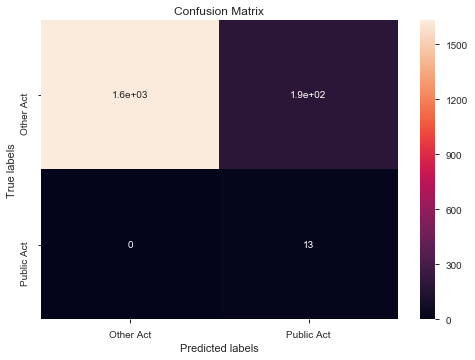

In [58]:
accuracy_lr2, counts_lr2, f1score_lr2, recall_lr2, precision_lr2, cm_lr2, FNR_lr2, mcc2 = LogisticReg(train_feature_oversampled, data_test, train_label_oversampled, label_test)
print('Accuracy for Logistic Regression After Random Oversampling: ', accuracy_lr2)
print('Recall for Logistic Regression After Random Oversampling: ', recall_lr2)
print('F1 score for Logistic Regression After Random Oversampling: ', f1score_lr2)
print('Precision for Logistic Regression After Random Oversampling: ', precision_lr2)
print('FNR for Logistic Regression with After Random Oversampling: ', FNR_lr2)
print('Mathews Correlation Coefficient for Logistic Regression After Random Oversampling: {0:.3} '.format(mcc2))

**Logistic Regression with Balanced Dataset After Applying Random Undersampling**

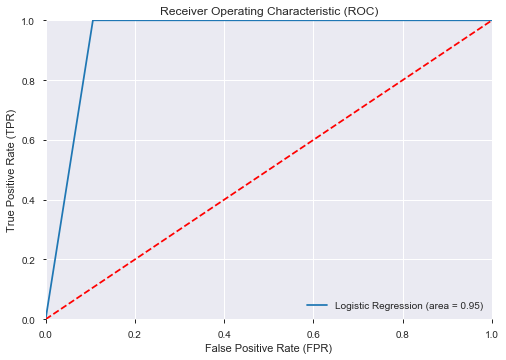

Area Under the Curve (AUC):   0.9470362239297475
Time took for training and predicting the results: 0.01562 seconds

Accuracy for Logistic Regression After Random Undersampling:  0.8948228882833787
Recall for Logistic Regression After Random Undersampling:  1.0
F1 score for Logistic Regression After Random Undersampling:  0.11872146118721462
Precision for Logistic Regression After Random Undersampling:  0.06310679611650485
FNR for Logistic Regression with After Random Undersampling:  0.0
Mathews Correlation Coefficient for Logistic Regression After Random Undersampling: 0.238 


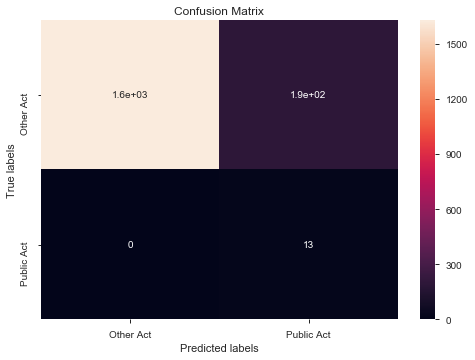

In [59]:
accuracy_lr3, counts_lr3, f1score_lr3, recall_lr3, precision_lr3, cm_lr3, FNR_lr3, mcc3 = LogisticReg(train_feature_undersampled, data_test, train_label_undersampled, label_test)
print('Accuracy for Logistic Regression After Random Undersampling: ', accuracy_lr3)
print('Recall for Logistic Regression After Random Undersampling: ', recall_lr3)
print('F1 score for Logistic Regression After Random Undersampling: ', f1score_lr3)
print('Precision for Logistic Regression After Random Undersampling: ', precision_lr3)
print('FNR for Logistic Regression with After Random Undersampling: ', FNR_lr3)
print('Mathews Correlation Coefficient for Logistic Regression After Random Undersampling: {0:.3} '.format(mcc3))

**Logistic Regression with Balanced Dataset After Applying SMOTE**

c:\users\ebhavaniprasad\pycharmprojects\test\venv\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


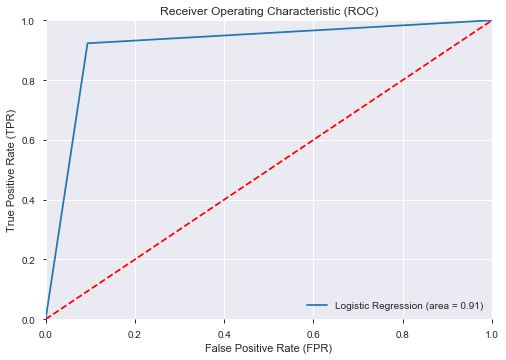

Area Under the Curve (AUC):   0.9146120070927973
Time took for training and predicting the results: 0.031243 seconds

Accuracy for Logistic Regression After SMOTE:  0.906267029972752
Recall for Logistic Regression After SMOTE:  0.9230769230769231
F1 score for Logistic Regression After SMOTE:  0.12244897959183675
Precision for Logistic Regression After SMOTE:  0.06557377049180328
FNR for Logistic Regression with After SMOTE:  0.07692307692307693
Mathews Correlation Coefficient for Logistic Regression After SMOTE: 0.232 


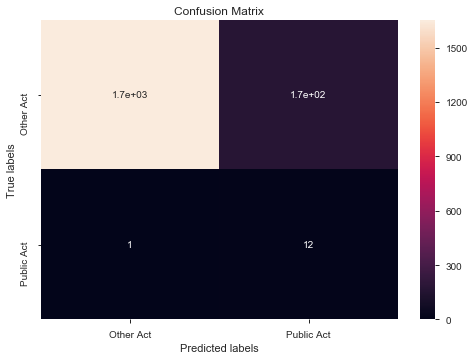

In [60]:
accuracy_lr4, counts_lr4, f1score_lr4, recall_lr4, precision_lr4, cm_lr4, FNR_lr4, mcc4 = LogisticReg(smote_feature_train_df, data_test, smote_label_train_df, label_test)
print('Accuracy for Logistic Regression After SMOTE: ', accuracy_lr4)
print('Recall for Logistic Regression After SMOTE: ', recall_lr4)
print('F1 score for Logistic Regression After SMOTE: ', f1score_lr4)
print('Precision for Logistic Regression After SMOTE: ', precision_lr4)
print('FNR for Logistic Regression with After SMOTE: ', FNR_lr4)
print('Mathews Correlation Coefficient for Logistic Regression After SMOTE: {0:.3} '.format(mcc4))

## Decision Tree

In [61]:
# Decision Tree

def DecisionTree(data_train, data_test, label_train, label_test):
    
    start = time.time()
    
    # Decision Tree model trains the data 
    dtc = tree.DecisionTreeClassifier(random_state=0)
    dtc = dtc.fit(data_train, label_train)    
   
    # Predicting the results for test data
    dtc_pred = dtc.predict(data_test)
    
    end = time.time()
    
    # Accuracy Score 
    accuracy = accuracy_score(label_test, dtc_pred)
    # F1 Score
    f1score = f1_score(label_test, dtc_pred)
    # Recall Score
    recall = recall_score(label_test, dtc_pred)
    # Precision Score
    precision = precision_score(label_test, dtc_pred)
    # Matthews Correlation Coefficient (MCC)
    mcc = matthews_corrcoef(label_test, dtc_pred) 
    
    
    # ROC Curve and AUROC Score.
    roc_auc = roc_auc_score(label_test, dtc_pred)
    
    fpr4, tpr4, thresholds4 = roc_curve(label_test, dtc_pred)
    plt.figure()
    plt.plot(fpr4, tpr4, label='Decision Tree (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

    print('Area Under the Curve (AUC):  ', roc_auc)
        
    print('Time took for training and predicting the results: {0:.5} seconds\n'.format(float(end-start)))
    
    # Checking unique values
    predictions = pd.DataFrame(dtc_pred)
    counts = predictions[0].value_counts()
    
    
    # Confusion Matrix 
    cm = confusion_matrix(label_test, dtc_pred)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells    
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Other Act', 'Public Act']); ax.yaxis.set_ticklabels(['Other Act', 'Public Act']);
   
    #FNR - False Negative Rate 
    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TP = cm[1][1]
    
    FNR = FN/(FN+TP)
    
    return accuracy, counts, f1score, recall, precision, cm, FNR, mcc 

**Decision Tree Classifier with Imbalanced (Original) Dataset**

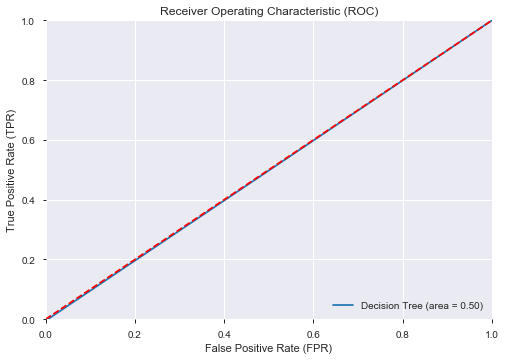

Area Under the Curve (AUC):   0.4975301866081229
Time took for training and predicting the results: 0.015621 seconds

Accuracy for Decision Tree with Imbalanced data (Original):  0.9880108991825614
Recall for Decision Tree with Imbalanced data (Original):  0.0
F1 score for Decision Tree with Imbalanced data (Original):  0.0
Precision for Decision Tree with Imbalanced data (Original):  0.0
FNR for Decision Tree with Imbalanced data (Original):  1.0
Mathews Correlation Coefficient for Decision Tree with Imbalanced data (Original): -0.00593 


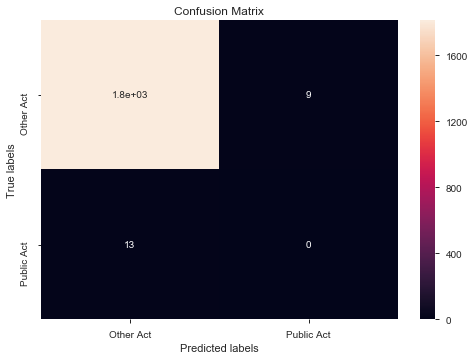

In [62]:
accuracy_dtc1, counts_dtc1, f1score_dtc1, recall_dtc1, precision_dtc1, cm_dtc1, FNR_dtc1, mcc1 = DecisionTree(data_train, data_test, label_train, label_test)
print('Accuracy for Decision Tree with Imbalanced data (Original): ', accuracy_dtc1)
print('Recall for Decision Tree with Imbalanced data (Original): ', recall_dtc1)
print('F1 score for Decision Tree with Imbalanced data (Original): ', f1score_dtc1)
print('Precision for Decision Tree with Imbalanced data (Original): ', precision_dtc1)
print('FNR for Decision Tree with Imbalanced data (Original): ', FNR_dtc1)
print('Mathews Correlation Coefficient for Decision Tree with Imbalanced data (Original): {0:.3} '.format(mcc1))

**Decision Tree Classifier with Balanced Dataset After Applying Random Oversampling**

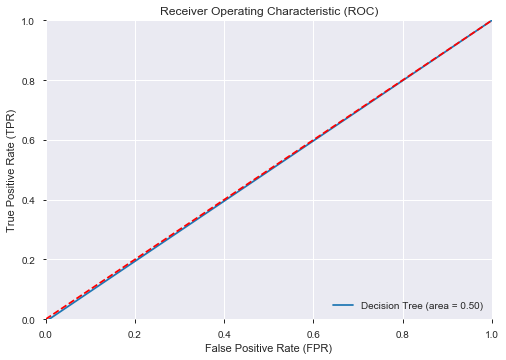

Area Under the Curve (AUC):   0.4961580680570801
Time took for training and predicting the results: 0.012089 seconds

Accuracy for Decision Tree After Random Oversampling:  0.9852861035422343
Recall for Decision Tree After Random Oversampling:  0.0
F1 score for Decision Tree After Random Oversampling:  0.0
Precision for Decision Tree After Random Oversampling:  0.0
FNR for Decision Tree with After Random Oversampling:  1.0
Mathews Correlation Coefficient for Decision Tree After Random Oversampling: -0.00741 


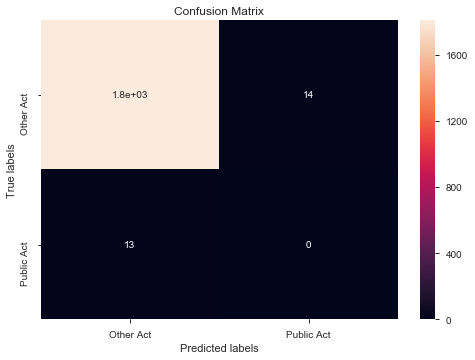

In [63]:
accuracy_dtc2, counts_dtc2, f1score_dtc2, recall_dtc2, precision_dtc2, cm_dtc2, FNR_dtc2, mcc2 = DecisionTree(train_feature_oversampled, data_test, train_label_oversampled, label_test)
print('Accuracy for Decision Tree After Random Oversampling: ', accuracy_dtc2)
print('Recall for Decision Tree After Random Oversampling: ', recall_dtc2)
print('F1 score for Decision Tree After Random Oversampling: ', f1score_dtc2)
print('Precision for Decision Tree After Random Oversampling: ', precision_dtc2)
print('FNR for Decision Tree with After Random Oversampling: ', FNR_dtc2)
print('Mathews Correlation Coefficient for Decision Tree After Random Oversampling: {0:.3} '.format(mcc2))

**Decision Tree Classifier with Balanced Dataset After Applying Random Undersampling**

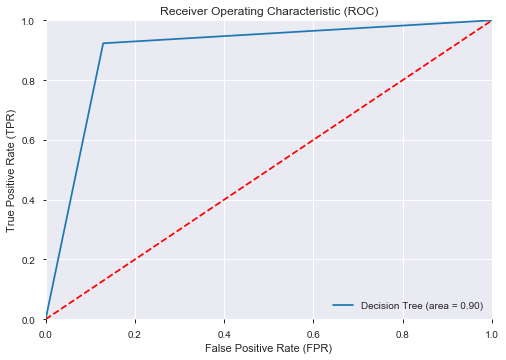

Area Under the Curve (AUC):   0.8970488896394495
Time took for training and predicting the results: 0.0 seconds

Accuracy for Decision Tree After Random Undersampling:  0.8713896457765667
Recall for Decision Tree After Random Undersampling:  0.9230769230769231
F1 score for Decision Tree After Random Undersampling:  0.09230769230769231
Precision for Decision Tree After Random Undersampling:  0.048582995951417005
FNR for Decision Tree with After Random Undersampling:  0.07692307692307693
Mathews Correlation Coefficient for Decision Tree After Random Undersampling: 0.195 


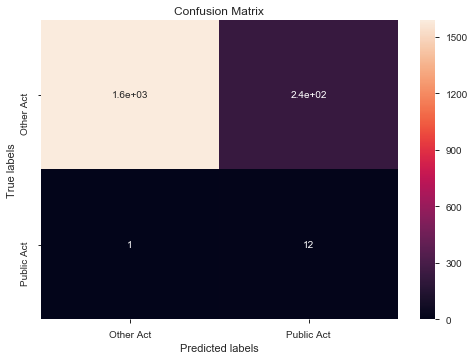

In [64]:
accuracy_dtc3, counts_dtc3, f1score_dtc3, recall_dtc3, precision_dtc3, cm_dtc3, FNR_dtc3, mcc3 = DecisionTree(train_feature_undersampled, data_test, train_label_undersampled, label_test)
print('Accuracy for Decision Tree After Random Undersampling: ', accuracy_dtc3)
print('Recall for Decision Tree After Random Undersampling: ', recall_dtc3)
print('F1 score for Decision Tree After Random Undersampling: ', f1score_dtc3)
print('Precision for Decision Tree After Random Undersampling: ', precision_dtc3)
print('FNR for Decision Tree with After Random Undersampling: ', FNR_dtc3)
print('Mathews Correlation Coefficient for Decision Tree After Random Undersampling: {0:.3} '.format(mcc3))

**Decision Tree Classifier with Balanced Dataset After Applying SMOTE**

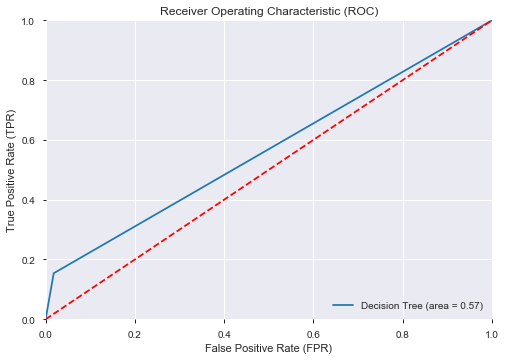

Area Under the Curve (AUC):   0.5678670944861943
Time took for training and predicting the results: 0.037857 seconds

Accuracy for Decision Tree After SMOTE:  0.9760217983651226
Recall for Decision Tree After SMOTE:  0.15384615384615385
F1 score for Decision Tree After SMOTE:  0.08333333333333333
Precision for Decision Tree After SMOTE:  0.05714285714285714
FNR for Decision Tree with After SMOTE:  0.8461538461538461
Mathews Correlation Coefficient for Decision Tree After SMOTE: 0.0832 


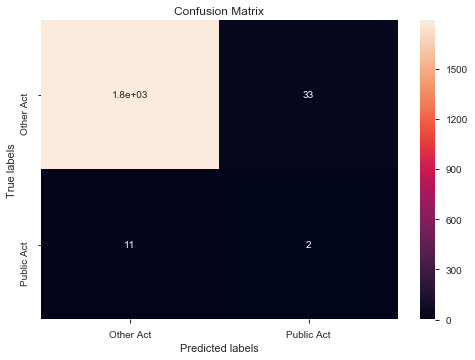

In [65]:
accuracy_dtc4, counts_dtc4, f1score_dtc4, recall_dtc4, precision_dtc4, cm_dtc4, FNR_dtc4, mcc4 = DecisionTree(smote_feature_train_df, data_test, smote_label_train_df, label_test)
print('Accuracy for Decision Tree After SMOTE: ', accuracy_dtc4)
print('Recall for Decision Tree After SMOTE: ', recall_dtc4)
print('F1 score for Decision Tree After SMOTE: ', f1score_dtc4)
print('Precision for Decision Tree After SMOTE: ', precision_dtc4)
print('FNR for Decision Tree with After SMOTE: ', FNR_dtc4)
print('Mathews Correlation Coefficient for Decision Tree After SMOTE: {0:.3} '.format(mcc4))

## Random Forest

In [66]:
# Random Forest
def Random_Forest(data_train, data_test, label_train, label_test):
    
    start = time.time()
    
    # Decision Tree model trains the data 
    rfc = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)

    #dtc = tree.DecisionTreeClassifier(random_state=0)
    rfc = rfc.fit(data_train, label_train)    
   
    # Predicting the results for test data
    rfc_pred = rfc.predict(data_test)
    
    end = time.time()
    
    # Accuracy Score 
    accuracy = accuracy_score(label_test, rfc_pred)
    # F1 Score
    f1score = f1_score(label_test, rfc_pred)
    # Recall Score
    recall = recall_score(label_test, rfc_pred)
    # Precision Score
    precision = precision_score(label_test, rfc_pred)
    # Matthews Correlation Coefficient (MCC)
    mcc = matthews_corrcoef(label_test, rfc_pred) 
    
    
    # ROC Curve and AUROC Score.
    roc_auc = roc_auc_score(label_test, rfc_pred)
    
    fpr4, tpr4, thresholds4 = roc_curve(label_test, rfc_pred)
    plt.figure()
    plt.plot(fpr4, tpr4, label='Random Forest (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

    print('Area Under the Curve (AUC):  ', roc_auc)
        
    print('Time took for training and predicting the results: {0:.5} seconds\n'.format(float(end-start)))
    
    # Checking unique values
    predictions = pd.DataFrame(rfc_pred)
    counts = predictions[0].value_counts()
    
    
    # Confusion Matrix 
    cm = confusion_matrix(label_test, rfc_pred)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells    
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Other Act', 'Public Act']); ax.yaxis.set_ticklabels(['Other Act', 'Public Act']);
   
    #FNR - False Negative Rate 
    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TP = cm[1][1]
    
    FNR = FN/(FN+TP)
    
    return accuracy, counts, f1score, recall, precision, cm, FNR, mcc 

**Random Forest Classifier with Imbalanced (Original) Dataset**

c:\users\ebhavaniprasad\pycharmprojects\test\venv\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
c:\users\ebhavaniprasad\pycharmprojects\test\venv\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\ebhavaniprasad\pycharmprojects\test\venv\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\ebhavaniprasad\pycharmprojects\test\venv\lib\site-packages\sklearn\metrics\classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sq

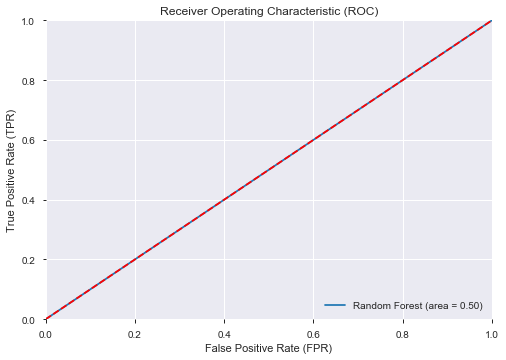

Area Under the Curve (AUC):   0.5
Time took for training and predicting the results: 0.21609 seconds

Accuracy for Random Forest with Imbalanced data (Original):  0.9929155313351499
Recall for Random Forest with Imbalanced data (Original):  0.0
F1 score for Random Forest with Imbalanced data (Original):  0.0
Precision for Random Forest with Imbalanced data (Original):  0.0
FNR for Random Forest with Imbalanced data (Original):  1.0
Mathews Correlation Coefficient for Random Forest with Imbalanced data (Original): 0.0 


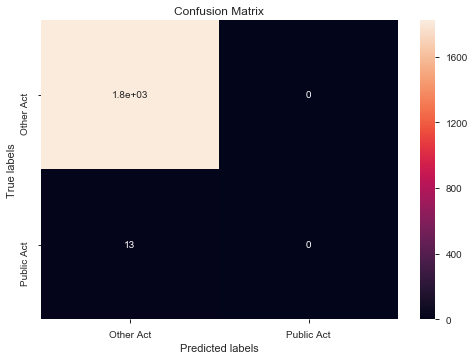

In [67]:
accuracy_rfc1, counts_rfc1, f1score_rfc1, recall_rfc1, precision_rfc1, cm_rfc1, FNR_rfc1, mcc1 = Random_Forest(data_train, data_test, label_train, label_test)
print('Accuracy for Random Forest with Imbalanced data (Original): ', accuracy_rfc1)
print('Recall for Random Forest with Imbalanced data (Original): ', recall_rfc1)
print('F1 score for Random Forest with Imbalanced data (Original): ', f1score_rfc1)
print('Precision for Random Forest with Imbalanced data (Original): ', precision_rfc1)
print('FNR for Random Forest with Imbalanced data (Original): ', FNR_rfc1)
print('Mathews Correlation Coefficient for Random Forest with Imbalanced data (Original): {0:.3} '.format(mcc1))

**Random Forest Classifier with Balanced Dataset After Applying Random Oversampling**

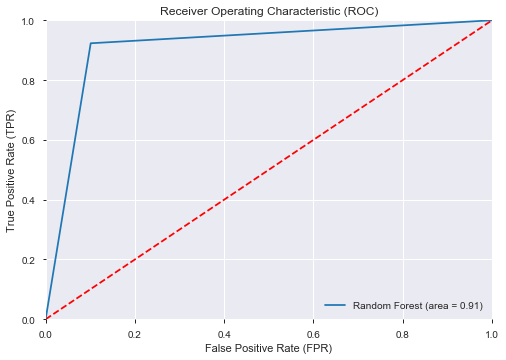

Area Under the Curve (AUC):   0.9110444988600861
Time took for training and predicting the results: 0.36968 seconds

Accuracy for Random Forest After Random Oversampling:  0.8991825613079019
Recall for Random Forest After Random Oversampling:  0.9230769230769231
F1 score for Random Forest After Random Oversampling:  0.11483253588516747
Precision for Random Forest After Random Oversampling:  0.061224489795918366
FNR for Random Forest with After Random Oversampling:  0.07692307692307693
Mathews Correlation Coefficient for Random Forest After Random Oversampling: 0.223 


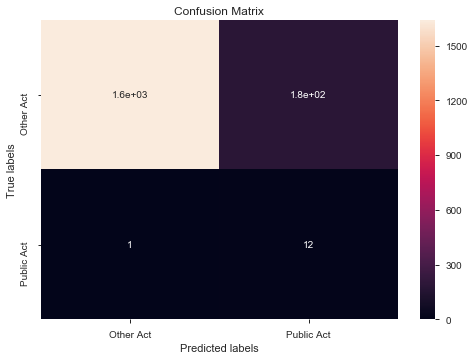

In [68]:
accuracy_rfc2, counts_rfc2, f1score_rfc2, recall_rfc2, precision_rfc2, cm_rfc2, FNR_rfc2, mcc2 = Random_Forest(train_feature_oversampled, data_test, train_label_oversampled, label_test)
print('Accuracy for Random Forest After Random Oversampling: ', accuracy_rfc2)
print('Recall for Random Forest After Random Oversampling: ', recall_rfc2)
print('F1 score for Random Forest After Random Oversampling: ', f1score_rfc2)
print('Precision for Random Forest After Random Oversampling: ', precision_rfc2)
print('FNR for Random Forest with After Random Oversampling: ', FNR_rfc2)
print('Mathews Correlation Coefficient for Random Forest After Random Oversampling: {0:.3} '.format(mcc2))

**Random Forest Classifier with Balanced Dataset After Applying Random Undersampling**

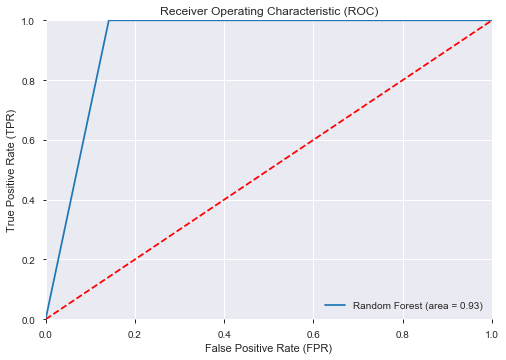

Area Under the Curve (AUC):   0.929198682766191
Time took for training and predicting the results: 0.11575 seconds

Accuracy for Random Forest After Random Undersampling:  0.8594005449591281
Recall for Random Forest After Random Undersampling:  1.0
F1 score for Random Forest After Random Undersampling:  0.09154929577464789
Precision for Random Forest After Random Undersampling:  0.04797047970479705
FNR for Random Forest with After Random Undersampling:  0.0
Mathews Correlation Coefficient for Random Forest After Random Undersampling: 0.203 


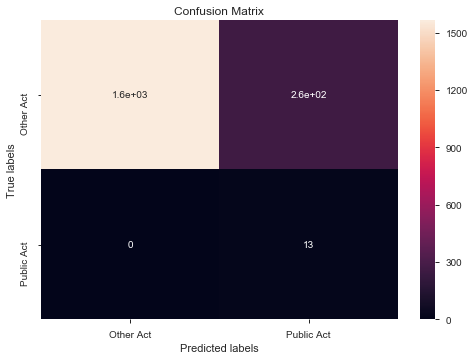

In [69]:
accuracy_rfc3, counts_rfc3, f1score_rfc3, recall_rfc3, precision_rfc3, cm_rfc3, FNR_rfc3, mcc3 = Random_Forest(train_feature_undersampled, data_test, train_label_undersampled, label_test)
print('Accuracy for Random Forest After Random Undersampling: ', accuracy_rfc3)
print('Recall for Random Forest After Random Undersampling: ', recall_rfc3)
print('F1 score for Random Forest After Random Undersampling: ', f1score_rfc3)
print('Precision for Random Forest After Random Undersampling: ', precision_rfc3)
print('FNR for Random Forest with After Random Undersampling: ', FNR_rfc3)
print('Mathews Correlation Coefficient for Random Forest After Random Undersampling: {0:.3} '.format(mcc3))

**Random Forest Classifier with Balanced Dataset After Applying SMOTE**

c:\users\ebhavaniprasad\pycharmprojects\test\venv\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


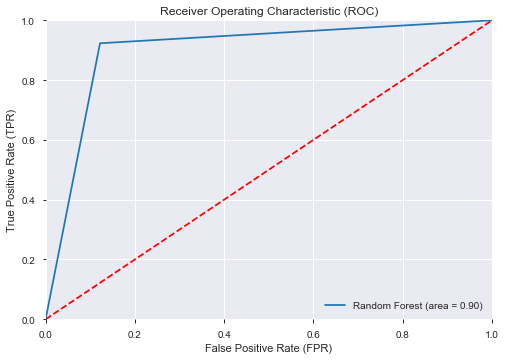

Area Under the Curve (AUC):   0.9006163978721607
Time took for training and predicting the results: 0.30078 seconds

Accuracy for Random Forest After SMOTE:  0.8784741144414169
Recall for Random Forest After SMOTE:  0.9230769230769231
F1 score for Random Forest After SMOTE:  0.097165991902834
Precision for Random Forest After SMOTE:  0.05128205128205128
FNR for Random Forest with After SMOTE:  0.07692307692307693
Mathews Correlation Coefficient for Random Forest After SMOTE: 0.201 


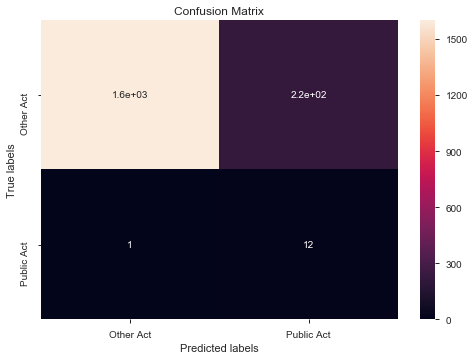

In [70]:
accuracy_rfc4, counts_rfc4, f1score_rfc4, recall_rfc4, precision_rfc4, cm_rfc4, FNR_rfc4, mcc4 = Random_Forest(smote_feature_train_df, data_test, smote_label_train_df, label_test)
print('Accuracy for Random Forest After SMOTE: ', accuracy_rfc4)
print('Recall for Random Forest After SMOTE: ', recall_rfc4)
print('F1 score for Random Forest After SMOTE: ', f1score_rfc4)
print('Precision for Random Forest After SMOTE: ', precision_rfc4)
print('FNR for Random Forest with After SMOTE: ', FNR_rfc4)
print('Mathews Correlation Coefficient for Random Forest After SMOTE: {0:.3} '.format(mcc4))

## XGBoost

In [71]:
# XGBoost

def XGBoost(data_train, data_test, label_train, label_test):
    
    start = time.time()
    
    # XGBoost model trains the data 
    xgbc = XGBClassifier()
    xgbc = xgbc.fit(data_train, label_train)    
   
    # Predicting the results for test data
    xgbc_pred = xgbc.predict(data_test)
    
    end = time.time()
    
    # Accuracy Score 
    accuracy = accuracy_score(label_test, xgbc_pred)
    # F1 Score
    f1score = f1_score(label_test, xgbc_pred)
    # Recall Score
    recall = recall_score(label_test, xgbc_pred)
    # Precision Score
    precision = precision_score(label_test, xgbc_pred)
    # Matthews Correlation Coefficient (MCC)
    mcc = matthews_corrcoef(label_test, xgbc_pred) 
    
    
    # ROC Curve and AUROC Score.
    roc_auc = roc_auc_score(label_test, xgbc_pred)
    
    fpr4, tpr4, thresholds4 = roc_curve(label_test, xgbc_pred)
    plt.figure()
    plt.plot(fpr4, tpr4, label='XGBoost (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

    print('Area Under the Curve (AUC):  ', roc_auc)
        
    print('Time took for training and predicting the results: {0:.5} seconds\n'.format(float(end-start)))
    
    # Checking unique values
    predictions = pd.DataFrame(xgbc_pred)
    counts = predictions[0].value_counts()
    
    
    # Confusion Matrix 
    cm = confusion_matrix(label_test, xgbc_pred)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells    
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Other Act', 'Public Act']); ax.yaxis.set_ticklabels(['Other Act', 'Public Act']);
   
    #FNR - False Negative Rate 
    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TP = cm[1][1]
    
    FNR = FN/(FN+TP)
    
    return accuracy, counts, f1score, recall, precision, cm, FNR, mcc 

**XGBoost Classifier with Imbalanced (Original) Dataset**

c:\users\ebhavaniprasad\pycharmprojects\test\venv\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\ebhavaniprasad\pycharmprojects\test\venv\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\ebhavaniprasad\pycharmprojects\test\venv\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\ebhavaniprasad\pycharmprojects\test\venv\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and b

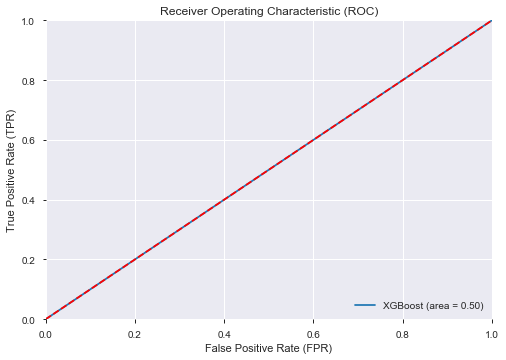

Area Under the Curve (AUC):   0.5
Time took for training and predicting the results: 0.48567 seconds

Accuracy for Random Forest with Imbalanced data (Original):  0.9929155313351499
Recall for Random Forest with Imbalanced data (Original):  0.0
F1 score for Random Forest with Imbalanced data (Original):  0.0
Precision for Random Forest with Imbalanced data (Original):  0.0
FNR for Random Forest with Imbalanced data (Original):  1.0
Mathews Correlation Coefficient for Random Forest with Imbalanced data (Original): 0.0 


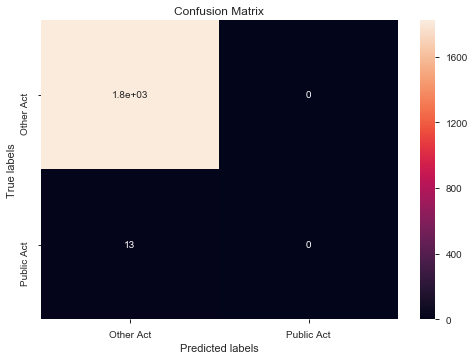

In [72]:
accuracy_xgbc1, counts_xgbc1, f1score_xgbc1, recall_xgbc1, precision_xgbc1, cm_xgbc1, FNR_xgbc1, mcc1 = XGBoost(data_train, data_test, label_train, label_test)
print('Accuracy for Random Forest with Imbalanced data (Original): ', accuracy_xgbc1)
print('Recall for Random Forest with Imbalanced data (Original): ', recall_xgbc1)
print('F1 score for Random Forest with Imbalanced data (Original): ', f1score_xgbc1)
print('Precision for Random Forest with Imbalanced data (Original): ', precision_xgbc1)
print('FNR for Random Forest with Imbalanced data (Original): ', FNR_xgbc1)
print('Mathews Correlation Coefficient for Random Forest with Imbalanced data (Original): {0:.3} '.format(mcc1))

**XGBoost Classifier with Balanced Dataset After Applying Random Oversampling**

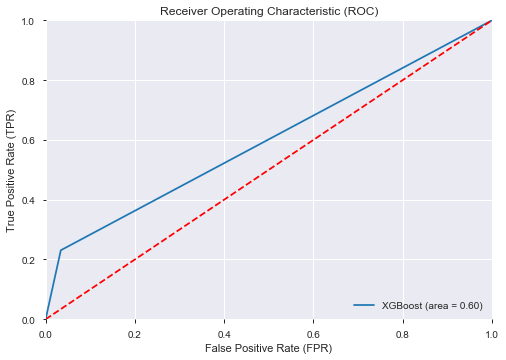

Area Under the Curve (AUC):   0.5983703453516847
Time took for training and predicting the results: 0.55054 seconds

Accuracy for XGBoost After Random Oversampling:  0.9607629427792915
Recall for XGBoost After Random Oversampling:  0.23076923076923078
F1 score for XGBoost After Random Oversampling:  0.07692307692307693
Precision for XGBoost After Random Oversampling:  0.046153846153846156
FNR for XGBoost with After Random Oversampling:  0.7692307692307693
Mathews Correlation Coefficient for XGBoost After Random Oversampling: 0.0893 


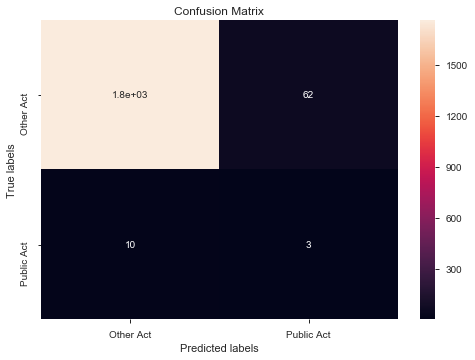

In [73]:
accuracy_xgbc2, counts_xgbc2, f1score_xgbc2, recall_xgbc2, precision_xgbc2, cm_xgbc2, FNR_xgbc2, mcc2 = XGBoost(train_feature_oversampled, data_test, train_label_oversampled, label_test)
print('Accuracy for XGBoost After Random Oversampling: ', accuracy_xgbc2)
print('Recall for XGBoost After Random Oversampling: ', recall_xgbc2)
print('F1 score for XGBoost After Random Oversampling: ', f1score_xgbc2)
print('Precision for XGBoost After Random Oversampling: ', precision_xgbc2)
print('FNR for XGBoost with After Random Oversampling: ', FNR_xgbc2)
print('Mathews Correlation Coefficient for XGBoost After Random Oversampling: {0:.3} '.format(mcc2))

**XGBoost Classifier with Balanced Dataset After Applying Random Undersampling**

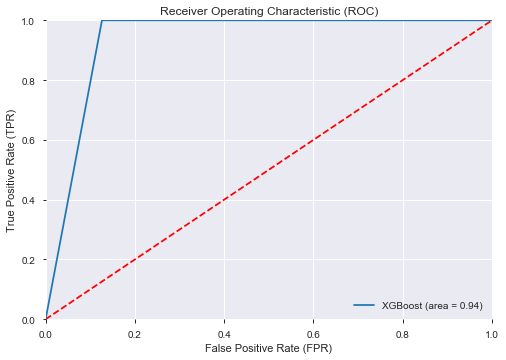

Area Under the Curve (AUC):   0.9368825466520307
Time took for training and predicting the results: 0.0156 seconds

Accuracy for XGBoost After Random Undersampling:  0.8746594005449592
Recall for XGBoost After Random Undersampling:  1.0
F1 score for XGBoost After Random Undersampling:  0.10156249999999999
Precision for XGBoost After Random Undersampling:  0.053497942386831275
FNR for XGBoost with After Random Undersampling:  0.0
Mathews Correlation Coefficient for XGBoost After Random Undersampling: 0.216 


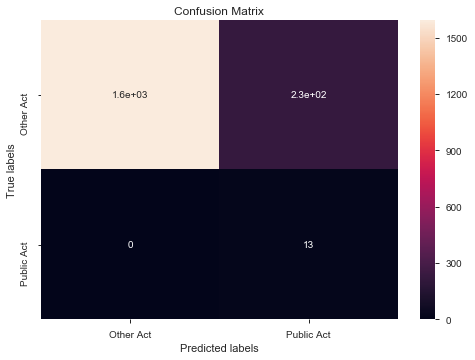

In [74]:
accuracy_xgbc3, counts_xgbc3, f1score_xgbc3, recall_xgbc3, precision_xgbc3, cm_xgbc3, FNR_xgbc3, mcc3 = XGBoost(train_feature_undersampled, data_test, train_label_undersampled, label_test)
print('Accuracy for XGBoost After Random Undersampling: ', accuracy_xgbc3)
print('Recall for XGBoost After Random Undersampling: ', recall_xgbc3)
print('F1 score for XGBoost After Random Undersampling: ', f1score_xgbc3)
print('Precision for XGBoost After Random Undersampling: ', precision_xgbc3)
print('FNR for XGBoost with After Random Undersampling: ', FNR_xgbc3)
print('Mathews Correlation Coefficient for XGBoost After Random Undersampling: {0:.3} '.format(mcc3))

**XGBoost Classifier with Balanced Dataset After Applying SMOTE**

c:\users\ebhavaniprasad\pycharmprojects\test\venv\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\ebhavaniprasad\pycharmprojects\test\venv\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


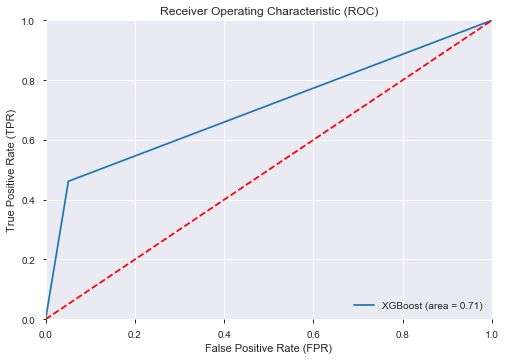

Area Under the Curve (AUC):   0.7052478257198346
Time took for training and predicting the results: 0.43236 seconds

Accuracy for XGBoost After SMOTE:  0.9455040871934605
Recall for XGBoost After SMOTE:  0.46153846153846156
F1 score for XGBoost After SMOTE:  0.10714285714285714
Precision for XGBoost After SMOTE:  0.06060606060606061
FNR for XGBoost with After SMOTE:  0.5384615384615384
Mathews Correlation Coefficient for XGBoost After SMOTE: 0.152 


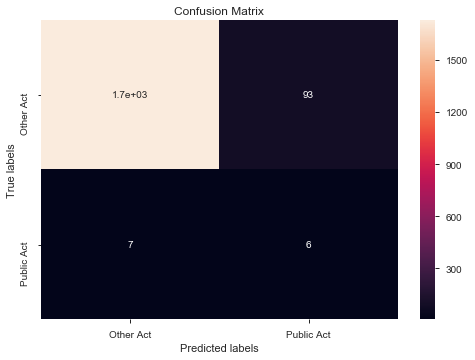

In [75]:
accuracy_xgbc4, counts_xgbc4, f1score_xgbc4, recall_xgbc4, precision_xgbc4, cm_xgbc4, FNR_xgbc4, mcc4 = XGBoost(smote_feature_train_df, data_test, smote_label_train_df, label_test)
print('Accuracy for XGBoost After SMOTE: ', accuracy_xgbc4)
print('Recall for XGBoost After SMOTE: ', recall_xgbc4)
print('F1 score for XGBoost After SMOTE: ', f1score_xgbc4)
print('Precision for XGBoost After SMOTE: ', precision_xgbc4)
print('FNR for XGBoost with After SMOTE: ', FNR_xgbc4)
print('Mathews Correlation Coefficient for XGBoost After SMOTE: {0:.3} '.format(mcc4))

<font color=Blue><h1>Part 5: Conclusion</h1></font>

1. From the plot it is clear that if the number of democrats sponsors are greater than 10 then the bill is **Other** Act <br>
2. For a given sample <br>
One additional democrat sponsor changes the probability that a bill is a Public Act is **1.2195 %**

# <center>Thank You!</center>